# Model training and testing
Author: Ida Thrane (idth@itu.dk)

In this notebook, the Random Classifier, Decistion Tree Model, DNN and CNN will be trained on the full training set and tested on the held-out test set. 

In [20]:
#Import libraries
import pandas as pd
from numpy import unique, bincount

from tensorflow.random import set_seed

from sklearn.metrics import accuracy_score as m_accuracy_score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score

from tensorflow.keras.losses import BinaryFocalCrossentropy
from keras import backend as K

from tensorflow import device
from tensorflow.test import gpu_device_name
device_name = gpu_device_name()
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.random import set_seed


from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import torch

from models import create_nn_model


In [3]:
#Set random state/seed to ensure reproducibility
random_state = 1

random.seed(random_state)                          
np.random.seed(random_state)                       
torch.manual_seed(random_state)                    
torch.cuda.manual_seed(random_state)               
torch.cuda.manual_seed_all(random_state)           
torch.backends.cudnn.deterministic = True  

## Load train and test set

In [4]:
with open('data/X_train.pickle', 'rb') as file:
    X_train = pd.read_pickle(file)
    X_train = X_train.values
    
with open('data/y_train.pickle', 'rb') as file:
    y_train = pd.read_pickle(file)
    y_train = y_train.values.ravel() 
    
with open('data/X_test.pickle', 'rb') as file:
    X_test = pd.read_pickle(file)
    
with open('data/y_test.pickle', 'rb') as file:
    y_test = pd.read_pickle(file)
    y_test = y_test.values.ravel()

In [4]:
X = np.concatenate([X_train, X_test])

y = np.concatenate([y_train, y_test])

## Define functions

In [12]:
#Define geometric mean evaluation metric
def geometric_mean_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    false_negatives = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    specificity = true_negatives / (true_negatives + false_positives + K.epsilon()) #Epsilon added to ensure there is no zero-division
    sensitivity = true_positives / (true_positives + false_negatives + K.epsilon()) #Epsilon added to ensure there is no zero-division
    return K.sqrt(specificity * sensitivity) 

### Training functions

In [88]:
###Train decision tree model
def train_dt_model(X, 
                   y, 
                   max_depth, 
                   class_weights, 
                   random_state,
                   save_model=False,
                   model_path=None):  
    
    #Instantiate model with the best hyperparameters found in the grid search 
    dt_model = create_dt_model(max_depth, 
                               random_state, 
                               class_weights)
    
    #Fit model
    history = dt_model.fit(X, 
                           y)
    
    if save_model:
        with open(model_path, 'wb') as file:
            pickle.dump(dt_model, file)
    return history

In [6]:
###Train DNN model
def train_nn_model(X,
                   y,
                   X_val,
                   y_val,
                   input_shape,
                   learning_rate,
                   loss,
                   n_epochs,
                   batch_size,
                   class_weight,
                   save_model=False,
                   model_path=None): 
    
    #Instantiate model with the best hyperparameters found in the grid search 
    nn_model = create_nn_model(input_shape = input_shape,
                               learning_rate = learning_rate,
                               loss=BinaryFocalCrossentropy(alpha=alpha, gamma=gamma))
    
    #Fit model
    history = nn_model.fit(X, 
                           y, 
                           epochs=n_epochs, 
                           batch_size=batch_size, 
                           class_weight=class_weight, 
                           validation_data = (X_val, y_val))
    
    if save_model:
        with open(model_path, 'wb') as file:
            pickle.dump(cnn_model, file)
    return history, nn_model

In [11]:
###Train CNN model
def train_cnn_model(X,
                    y,
                    X_val,
                    y_val,
                    input_shape,
                    learning_rate,
                    loss,
                    n_epochs,
                    batch_size, 
                    class_weight =  class_weight,
                    save_model=False,
                    model_path=None):   
    
    #Instantiate model with the best hyperparameters found in the grid search 
    cnn_model = create_cnn_model(input_shape = input_shape,
                                 learning_rate = learning_rate,
                                 loss=BinaryFocalCrossentropy(alpha=alpha, gamma=gamma))
    
    #Fit model   
    history = cnn_model.fit(X, 
                            y, 
                            epochs=n_epochs, 
                            batch_size=batch_size, 
                            class_weight=class_weight, 
                            validation_data = (X_val, y_val)) 
    
    if save_model:
        with open(model_path, 'wb') as file:
            pickle.dump(cnn_model, file)
    return history, cnn_model

### Testing functions

In [82]:
###Test Decision tree model    
def test_dt_model(X_train,
                  y_train,
                  X_test,
                  y_test,
                  dt_model,
                  max_depth,
                  class_weights,
                  random_state):  
    
    #Predict  
    predictions = dt_model.predict(X_test)

    #Calculate geometric mean of the predictions
    predictions_reshaped=predictions.reshape(len(predictions),1).ravel()
    geometric_mean_score = geometric_mean_metric(y_test, predictions_reshaped)

    #Print results
    print("Accuracy:",metrics.accuracy_score(y_test, predictions))
    print("Geometric mean: ", geometric_mean_score)
    print("Confusion matrix:",metrics.confusion_matrix(y_test, predictions))

In [7]:
###Test DNN model
def test_nn_model(X_train,
                  y_train,
                  X_test,
                  y_test,
                  nn_model,
                  input_shape,
                  learning_rate,
                  loss,
                  n_epochs,
                  batch_size,
                  class_weight):  

    #Probabilities of predicted points
    probas = nn_model.predict(X_test)
    #Predict  
    predictions = (probas > 0.5).reshape(y_test.shape[0])

    #Print results
    print("Accuracy:",metrics.accuracy_score(y_test, predictions))
    
    #Reshape predictions to calculate geometric mean
    predictions_reshaped=predictions.reshape(len(predictions),1).ravel()
    geometric_mean_score = geometric_mean_metric(y_test, predictions_reshaped)
    print("Geometric mean: ", geometric_mean_score)
    
    print("Train accuracy: ", np.mean(history.history['accuracy']))
    print("Train g_mean: ", np.mean(history.history['geometric_mean_metric']))
    print("Train loss: ", np.mean(history.history['loss']))

    print("Val accuracy: ", np.mean(history.history['val_accuracy']))
    print("Val g_mean: ", np.mean(history.history['val_geometric_mean_metric']))
    print("Val loss: ", np.mean(history.history['val_loss']))

    #Print confusion matrix
    print(tf.math.confusion_matrix(
    y_test,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None))

    #Plot geometric score for each epoch in training
    plt.plot(history.history['geometric_mean_metric'])
    plt.axhline(y=geometric_mean_score, color = 'green', linestyle='-')
    #Plot validation score
    plt.plot(history.history['val_geometric_mean_metric'])
    plt.title('model geometric mean')
    plt.ylabel('geometric mean')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    #Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return y_test, predictions, probas

In [55]:
###Test CNN model
def test_cnn_model(X_train,
                   y_train,
                   X_test,
                   y_test,
                   cnn_model,
                   input_shape,
                   learning_rate, 
                   loss,
                   n_epochs,
                   batch_size, 
                   class_weight):  

    #Probabilities of predicted points
    probas = cnn_model.predict(X_test)
    #Predict  
    predictions = (probas > 0.5).reshape(y_test.shape[0])

    #Print results
    print("Accuracy:",metrics.accuracy_score(y_test, predictions))
   
    #Reshape predictions to calculate geometric mean
    predictions_reshaped=predictions.reshape(len(predictions),1).ravel()
    geometric_mean_score = geometric_mean_metric(y_test, predictions_reshaped)
    print("Geometric mean: ", geometric_mean_score)
    
    print("Train accuracy: ", np.mean(history.history['accuracy']))
    print("Train g_mean: ", np.mean(history.history['geometric_mean_metric']))
    print("Train loss: ", np.mean(history.history['loss']))

    print("Val accuracy: ", np.mean(history.history['val_accuracy']))
    print("Val g_mean: ", np.mean(history.history['val_geometric_mean_metric']))
    print("Val loss: ", np.mean(history.history['val_loss']))

    #Print confusion matrix
    print(tf.math.confusion_matrix(
    y_test,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None))

    #Plot geometric score for each epoch in training
    plt.plot(history.history['geometric_mean_metric'])
    plt.axhline(y=geometric_mean_score, color = 'green', linestyle='-')
    #Plot validation score
    plt.plot(history.history['val_geometric_mean_metric'])
    plt.title('model geometric mean')
    plt.ylabel('geometric mean')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    #Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return y_test, predictions, probas

# Training models

### Train decision tree model

In [77]:
###Instantiate variables
random_state = random_state
set_seed(random_state)

# Define inverse class weights
weight_minor_class, weight_major_class = len(y_train) / (len(unique(y_train)) * bincount(y_train.ravel().astype('int64')))

#Define class weights
class_weight = {0:1, 1:50}

#Define tree depth
max_depth = 100

#Define sampling strategy for oversampling
sampling_strategy = 0.5


In [83]:
###Train decision tree model

#Create oversample
oversample = RandomOverSampler(sampling_strategy=0.5, 
                               random_state=random_state)
oversampled_X_train, oversampled_y_train = oversample.fit_resample(X_train, 
                                                                   y_train)

#Shuffle data
oversampled_X_train, oversampled_y_train = shuffle(oversampled_X_train, 
                                                   oversampled_y_train, 
                                                   random_state = random_state)

#Train model
dt_model = train_dt_model(X=oversampled_X_train, 
                          y=oversampled_y_train, 
                          max_depth=max_depth, 
                          class_weight=class_weight, 
                          random_state=random_state)

### Train DNN model

In [15]:
#Instantiate variables

#Set random state
random_state = random_state
set_seed(random_state)

#Define inverse class weights
weight_major_class, weight_minor_class = len(y_train) / (len(unique(y_train)) * bincount(y_train.ravel().astype('int64')))

#Define dropout rate
dropout_rate = 0.3

#Define input shape
input_shape = X_train.shape[1]

#Define alpha as inverse class weight
alpha = bincount(y_train.ravel().astype('int64'))[0]/len(y_train)

#Define gamma
gamma = 1.

#Define loss function
loss = BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)

#Define learning rate
learning_rate = 0.001

#Define class weights
class_weight = {0: 1, 1: 1}

#Define batch size
batch_size = 32

#Define number of epochs
n_epochs = 50

In [47]:
###Train DNN model

#Create validation data with 10% of the training data
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size = 0.1, 
                                                              random_state = random_state)

#Create oversample
oversample = RandomOverSampler(sampling_strategy=0.5, 
                               random_state=random_state)

oversampled_X_small, oversampled_y_small = oversample.fit_resample(X_train_small, 
                                                                   y_train_small)

#Train DNN model
history, nn_model = train_nn_model(X = oversampled_X_small,
                                   y = oversampled_y_small,
                                   X_val=X_val,
                                   y_val = y_val,
                                   input_shape = input_shape, 
                                   learning_rate = learning_rate,
                                   loss = loss,
                                   n_epochs = n_epochs,
                                   batch_size = batch_size, 
                                   class_weight =  class_weight)

Epoch 1/50
3706/3706 [==============================] - 11s 3ms/step - loss: 0.2719 - accuracy: 0.7348 - geometric_mean_metric: 0.6228 - val_loss: 0.1850 - val_accuracy: 0.8794 - val_geometric_mean_metric: 0.4808
Epoch 2/50
3706/3706 [==============================] - 10s 3ms/step - loss: 0.2548 - accuracy: 0.7639 - geometric_mean_metric: 0.6734 - val_loss: 0.1690 - val_accuracy: 0.8681 - val_geometric_mean_metric: 0.5014
Epoch 3/50
3706/3706 [==============================] - 9s 2ms/step - loss: 0.2507 - accuracy: 0.7678 - geometric_mean_metric: 0.6842 - val_loss: 0.1865 - val_accuracy: 0.8488 - val_geometric_mean_metric: 0.5398
Epoch 4/50
3706/3706 [==============================] - 9s 2ms/step - loss: 0.2483 - accuracy: 0.7708 - geometric_mean_metric: 0.6929 - val_loss: 0.1972 - val_accuracy: 0.8408 - val_geometric_mean_metric: 0.5491
Epoch 5/50
3706/3706 [==============================] - 9s 3ms/step - loss: 0.2478 - accuracy: 0.7709 - geometric_mean_metric: 0.6908 - val_loss: 0.18

### Train CNN model

In [54]:
###Train CNN model

#Create validation data with 10% of the training data
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size = 0.1, 
                                                              random_state = random_state)

#Create oversample
oversample = RandomOverSampler(sampling_strategy=0.5, 
                               random_state=random_state)

oversampled_X_small, oversampled_y_small = oversample.fit_resample(X_train_small, 
                                                                   y_train_small)

#Train CNN model
history, cnn_model = train_cnn_model(X = oversampled_X_small,
                                     y = oversampled_y_small,
                                     X_val=X_val,
                                     y_val = y_val,
                                     input_shape = input_shape, 
                                     learning_rate = learning_rate,
                                     loss = loss,
                                     n_epochs = n_epochs,
                                     batch_size = batch_size, 
                                     class_weight =  class_weight)

Epoch 1/50
3706/3706 [==============================] - 13s 3ms/step - loss: 0.2716 - accuracy: 0.7349 - geometric_mean_metric: 0.6092 - val_loss: 0.1661 - val_accuracy: 0.8885 - val_geometric_mean_metric: 0.4472
Epoch 2/50
3706/3706 [==============================] - 12s 3ms/step - loss: 0.2515 - accuracy: 0.7665 - geometric_mean_metric: 0.6803 - val_loss: 0.1619 - val_accuracy: 0.8723 - val_geometric_mean_metric: 0.4990
Epoch 3/50
3706/3706 [==============================] - 11s 3ms/step - loss: 0.2480 - accuracy: 0.7702 - geometric_mean_metric: 0.6892 - val_loss: 0.1640 - val_accuracy: 0.8677 - val_geometric_mean_metric: 0.5192
Epoch 4/50
3706/3706 [==============================] - 10s 3ms/step - loss: 0.2460 - accuracy: 0.7718 - geometric_mean_metric: 0.6942 - val_loss: 0.1789 - val_accuracy: 0.8597 - val_geometric_mean_metric: 0.5422
Epoch 5/50
3706/3706 [==============================] - 10s 3ms/step - loss: 0.2450 - accuracy: 0.7735 - geometric_mean_metric: 0.6962 - val_loss: 0

# Testing models

### Test random model

In [56]:
###Random model

#Calculate random predictions
random_predictions = random_model(X_train, 
                                  X_test)

#Print results
print("Geometric mean: ", geometric_mean_metric(y_test, np.array(random_predictions).ravel()))
print("Accuracy:",metrics.accuracy_score(y_test, np.array(random_predictions)))

Geometric mean:  tf.Tensor(0.4851649307831373, shape=(), dtype=float64)
Accuracy: 0.5007683442182097


### Test Decision tree model

In [85]:
test_dt_model(X_train= oversampled_X_train,
              y_train = oversampled_y_train,
              X_test = X_test,
              y_test = y_test,
              dt_model=dt_model,
              max_depth = max_depth,
              class_weights = class_weight,
              n_splits = n_splits, 
              random_state = random_state)

Accuracy: 0.8069535151747983
Geometric mean:  tf.Tensor(0.3594814556869798, shape=(), dtype=float64)
Confusion matrix: [[8203  807]
 [1203  199]]


### Test DNN model

326/326 [==============================] - 1s 1ms/step
Accuracy: 0.7912985017287745
Geometric mean:  tf.Tensor(0.7203496556894057, shape=(), dtype=float64)
Train accuracy:  0.7796982753276825
Train g_mean:  0.7077208769321441
Train loss:  0.23865841537714005
Val accuracy:  0.8521289098262786
Val g_mean:  0.5482283073663712
Val loss:  0.18366434842348098
tf.Tensor(
[[7814 1942]
 [ 231  425]], shape=(2, 2), dtype=int32)


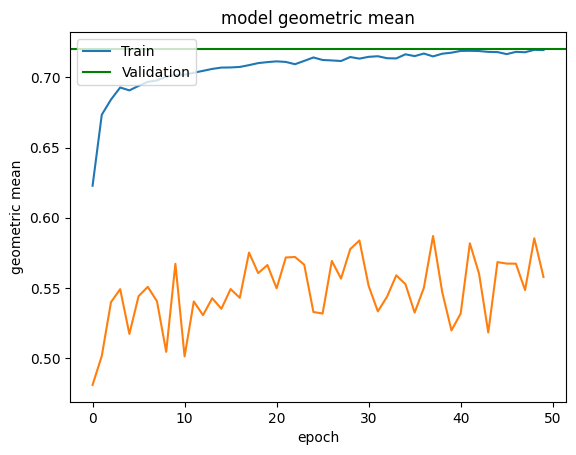

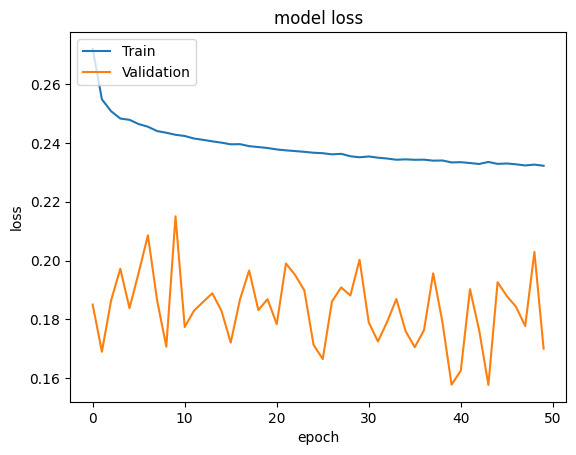

In [49]:
y_test, predictions, probas = test_nn_model(X_train = oversampled_X_small, 
                                            y_train = oversampled_y_small, 
                                            nn_model = nn_model,
                                            X_test = X_test,
                                            y_test = y_test,
                                            input_shape = input_shape, 
                                            learning_rate = learning_rate, 
                                            loss = loss,
                                            n_epochs = n_epochs,
                                            batch_size = batch_size, 
                                            class_weight = class_weight)

### Save DNN Predictions

In [90]:
#pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')
#pd.DataFrame(probas, columns=['probas']).to_csv('probas.csv')

### Test CNN model

326/326 [==============================] - 0s 1ms/step
Accuracy: 0.7298309642719939
Geometric mean:  tf.Tensor(0.7249975904301678, shape=(), dtype=float64)
Train accuracy:  0.7830133664608002
Train g_mean:  0.7129014325141907
Train loss:  0.23421070635318755
Val accuracy:  0.8642791545391083
Val g_mean:  0.5266234838962555
Val loss:  0.17120305716991424
tf.Tensor(
[[7127 2629]
 [ 184  472]], shape=(2, 2), dtype=int32)


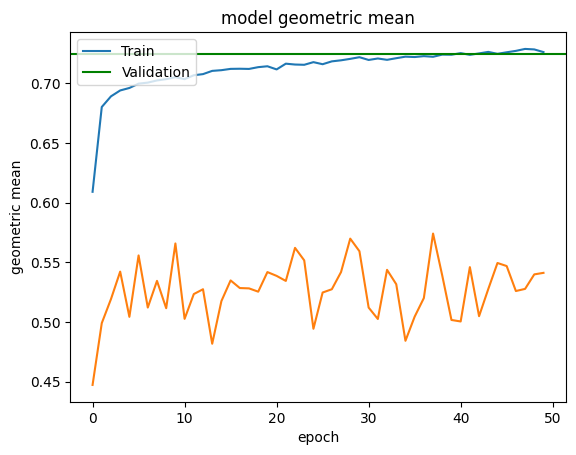

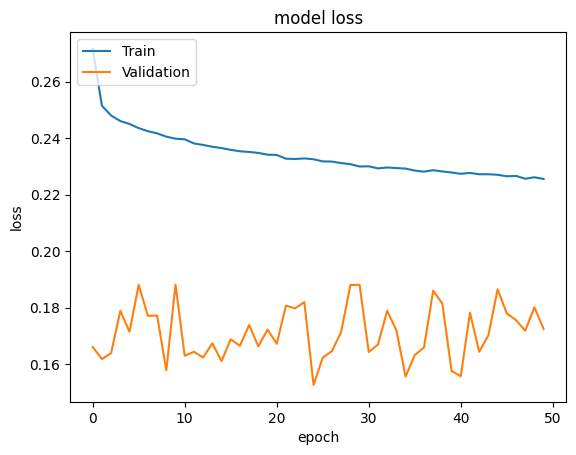

In [56]:
y_test, predictions, probas = test_cnn_model(X_train =oversampled_X_small, 
                                             y_train = oversampled_y_small, 
                                             X_test = X_test,
                                             y_test = y_test,
                                             cnn_model = cnn_model,
                                             input_shape = input_shape,
                                             learning_rate = learning_rate, 
                                             loss = loss,
                                             n_epochs = n_epochs,
                                             batch_size = batch_size,
                                             class_weight = class_weight)

### Save CNN predictions

In [89]:
#pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')
#pd.DataFrame(probas, columns=['probas']).to_csv('probas.csv')

# Experiment 2: Test CNN on all streets (both containing park trees,  street trees etc.)

### Load data

In [57]:
with open('data/X_train_all.pickle', 'rb') as file:
    X_train_all = pd.read_pickle(file)
    X_train_all = X_train_all.values
    
with open('data/y_train_all.pickle', 'rb') as file:
    y_train_all = pd.read_pickle(file)
    y_train_all = y_train_all.values.ravel() 
    
with open('data/X_test_all.pickle', 'rb') as file:
    X_test_all = pd.read_pickle(file)
    
with open('data/y_test_all.pickle', 'rb') as file:
    y_test_all = pd.read_pickle(file)
    y_test_all = y_test_all.values.ravel()

### Train CNN model

In [19]:
###Instantiate variables

#Set random state
random_state = random_state
set_seed(random_state)

#Define inverse class weights
weight_major_class, weight_minor_class = len(y_train_all) / (len(unique(y_train_all)) * bincount(y_train_all.ravel().astype('int64')))

#Define dropout rate
dropout_rate = 0.3

#Define input shape
input_shape = X_train_all.shape[1]

#Define alpha as inverse class weight
alpha = bincount(y_train_all.ravel().astype('int64'))[0]/len(y_train_all)

#Define gamma
gamma = 0.

#Define loss function
loss = BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)

#Define learning rate
learning_rate = 0.001

#Define class weights
class_weight = {0: 1, 1: 1}

#Define batch size
batch_size = 32

#Define number of epochs
n_epochs = 10

In [67]:
###Train CNN model

#Create validation data with 10% of the training data
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train_all, 
                                                              y_train_all, 
                                                              test_size = 0.1, 
                                                              random_state = random_state)

#Create oversample
oversample = RandomOverSampler(sampling_strategy=0.5, 
                               random_state=random_state)

oversampled_X_small, oversampled_y_small = oversample.fit_resample(X_train_small, 
                                                                   y_train_small)

#Train CNN model
history, cnn_model = train_cnn_model(X = oversampled_X_small,
                                     y = oversampled_y_small,
                                     X_val=X_val,
                                     y_val = y_val,
                                     input_shape = input_shape, 
                                     learning_rate = learning_rate,
                                     loss = loss,
                                     n_epochs = n_epochs,
                                     batch_size = batch_size, 
                                     class_weight =  class_weight)

Epoch 1/10
3404/3404 [==============================] - 11s 3ms/step - loss: 0.5793 - accuracy: 0.7012 - geometric_mean_metric: 0.4298 - val_loss: 0.4192 - val_accuracy: 0.8191 - val_geometric_mean_metric: 0.5028
Epoch 2/10
3404/3404 [==============================] - 10s 3ms/step - loss: 0.5461 - accuracy: 0.7251 - geometric_mean_metric: 0.6075 - val_loss: 0.4780 - val_accuracy: 0.7672 - val_geometric_mean_metric: 0.6353
Epoch 3/10
3404/3404 [==============================] - 9s 3ms/step - loss: 0.5386 - accuracy: 0.7297 - geometric_mean_metric: 0.6241 - val_loss: 0.4151 - val_accuracy: 0.8057 - val_geometric_mean_metric: 0.6026
Epoch 4/10
3404/3404 [==============================] - 10s 3ms/step - loss: 0.5330 - accuracy: 0.7337 - geometric_mean_metric: 0.6331 - val_loss: 0.4228 - val_accuracy: 0.7967 - val_geometric_mean_metric: 0.6189
Epoch 5/10
3404/3404 [==============================] - 9s 3ms/step - loss: 0.5288 - accuracy: 0.7371 - geometric_mean_metric: 0.6360 - val_loss: 0.4

### Test CNN model

326/326 [==============================] - 0s 1ms/step
Accuracy: 0.6939108720706877
Geometric mean:  tf.Tensor(0.7175657087311338, shape=(), dtype=float64)
Train accuracy:  0.7334505617618561
Train g_mean:  0.6160848617553711
Train loss:  0.5331434190273285
Val accuracy:  0.8079287230968475
Val g_mean:  0.5936281204223632
Val loss:  0.41899738013744353
tf.Tensor(
[[6171 2839]
 [ 348 1054]], shape=(2, 2), dtype=int32)


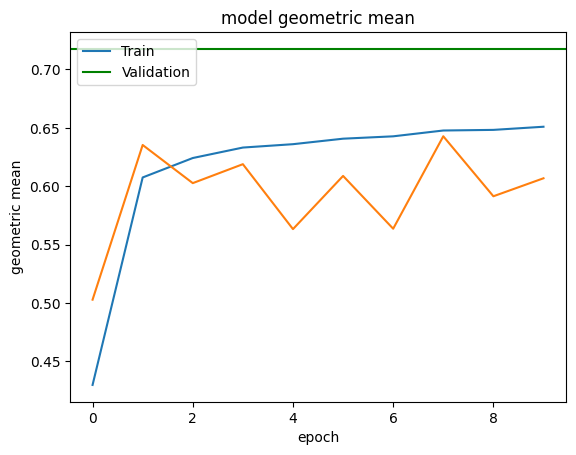

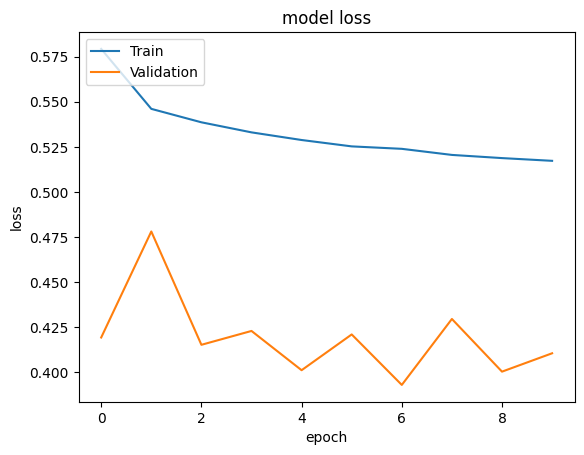

In [68]:
y_test, predictions, probas = test_cnn_model(X_train =oversampled_X_small, 
                                             y_train = oversampled_y_small, 
                                             X_test = X_test_all,
                                             y_test = y_test_all,
                                             cnn_model = cnn_model,
                                             input_shape = input_shape,
                                             learning_rate = learning_rate, 
                                             loss = loss,
                                             n_epochs = n_epochs,
                                             batch_size = batch_size,
                                             class_weight = class_weight)

### Save Predictions of all tree types

In [91]:
#pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction_all.csv')
#pd.DataFrame(probas, columns=['probas']).to_csv('probas_all.csv')

# Experiment 3: Test on only street features

### Load data

In [62]:
with open('data/X_train_streets.pickle', 'rb') as file:
    X_train_streets = pd.read_pickle(file)
    X_train_streets = X_train_streets.values
    
with open('data/y_train_streets.pickle', 'rb') as file:
    y_train_streets = pd.read_pickle(file)
    y_train_streets = y_train_streets.values.ravel() 
    
with open('data/X_test_streets.pickle', 'rb') as file:
    X_test_streets = pd.read_pickle(file)
    
with open('data/y_test_streets.pickle', 'rb') as file:
    y_test_streets = pd.read_pickle(file)
    y_test_streets = y_test_streets.values.ravel()

### Train CNN model

In [63]:
#Instantiate variables

weight_major_class, weight_minor_class = len(y_train_streets) / (len(unique(y_train_streets)) * bincount(y_train_streets.ravel().astype('int64')))

# Set random state
random_state = 1
set_seed(random_state)

dropout_rate = 0.3

n_splits = 10

input_shape = X_train_streets.shape[1]

alpha = bincount(y_train_streets.ravel().astype('int64'))[0]/len(y_train_streets), # inverse class weight

gamma = 0.

loss = BinaryFocalCrossentropy(alpha=alpha, gamma=gamma)

learning_rate = 0.001

#ÆNDR I FORHOLD TIL GRID
#class_weight = {0: weight_major_class, 1: weight_minor_class}
class_weight = {0: 1, 1: 1}

batch_size = 32

n_epochs = 25

# Define which metrics to show for Keras models
#metrics = {'accuracy': m_accuracy_score,
#           'g-mean': geometric_mean_score}

#refitting_metric = 'g-mean'

In [64]:
###Train CNN model

#Create validation data with 10% of the training data
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train_streets, 
                                                              y_train_streets, 
                                                              test_size = 0.1, 
                                                              random_state = random_state)

#Create oversample
oversample = RandomOverSampler(sampling_strategy=0.5, 
                               random_state=random_state)

oversampled_X_small, oversampled_y_small = oversample.fit_resample(X_train_small, 
                                                                   y_train_small)

#Train CNN model
history, cnn_model = train_cnn_model(X = oversampled_X_small,
                                     y = oversampled_y_small,
                                     X_val = X_val,
                                     y_val = y_val,
                                     input_shape = input_shape, 
                                     learning_rate = learning_rate,
                                     loss = loss,
                                     n_epochs = n_epochs,
                                     batch_size = batch_size, 
                                     class_weight =  class_weight)

Epoch 1/25
3706/3706 [==============================] - 9s 2ms/step - loss: 0.5642 - accuracy: 0.7080 - geometric_mean_metric: 0.5174 - val_loss: 0.3540 - val_accuracy: 0.8649 - val_geometric_mean_metric: 0.4291
Epoch 2/25
3706/3706 [==============================] - 7s 2ms/step - loss: 0.5326 - accuracy: 0.7322 - geometric_mean_metric: 0.6526 - val_loss: 0.3497 - val_accuracy: 0.8213 - val_geometric_mean_metric: 0.5033
Epoch 3/25
3706/3706 [==============================] - 7s 2ms/step - loss: 0.5290 - accuracy: 0.7334 - geometric_mean_metric: 0.6663 - val_loss: 0.3610 - val_accuracy: 0.8219 - val_geometric_mean_metric: 0.4962
Epoch 4/25
3706/3706 [==============================] - 7s 2ms/step - loss: 0.5274 - accuracy: 0.7348 - geometric_mean_metric: 0.6681 - val_loss: 0.4006 - val_accuracy: 0.7872 - val_geometric_mean_metric: 0.5496
Epoch 5/25
3706/3706 [==============================] - 7s 2ms/step - loss: 0.5264 - accuracy: 0.7350 - geometric_mean_metric: 0.6686 - val_loss: 0.3986

### Test CNN model

326/326 [==============================] - 0s 874us/step
Accuracy: 0.833941605839416
Geometric mean:  tf.Tensor(0.6238322724128085, shape=(), dtype=float64)
Train accuracy:  0.7366010880470276
Train g_mean:  0.6620938277244568
Train loss:  0.5250928425788879
Val accuracy:  0.8209283995628357
Val g_mean:  0.499400897026062
Val loss:  0.38615212559700013
tf.Tensor(
[[8386 1370]
 [ 359  297]], shape=(2, 2), dtype=int32)


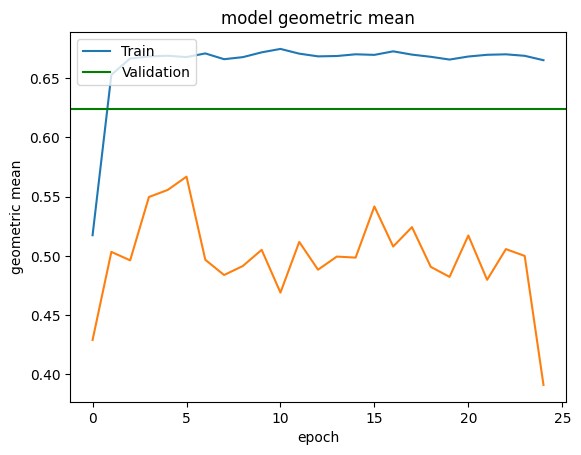

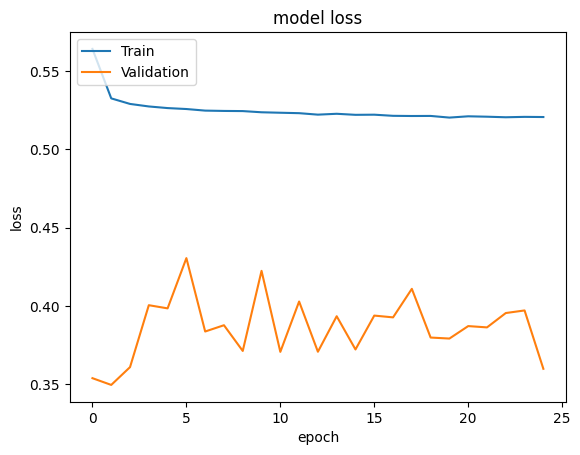

In [65]:
y_test, predictions, probas = test_cnn_model(X_train =oversampled_X_small, 
                                             y_train = oversampled_y_small, 
                                             X_test = X_test_streets,
                                             y_test = y_test_streets,
                                             cnn_model = cnn_model,
                                             input_shape = input_shape,
                                             learning_rate = learning_rate, 
                                             loss = loss,
                                             n_epochs = n_epochs,
                                             batch_size = batch_size,
                                             class_weight = class_weight)

### Save predictions for only street features

In [92]:
#pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction_street.csv')
#pd.DataFrame(probas, columns=['probas']).to_csv('probas_street.csv')